In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import itertools

import warnings
warnings.filterwarnings('ignore')

#nltk.download('averaged_perceptron_tagger')

In [2]:
train=pd.read_csv('fake-news/train.csv')


In [3]:
test=pd.read_csv('fake-news/test.csv')

In [4]:
dataset=pd.read_csv('fake-news/submit.csv')

In [5]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
train.shape

(20800, 5)

In [7]:
train = train[train.text.notnull()]

In [8]:
train.shape

(20761, 5)

we can benefit from associating authors with different topics but only if authors are duplicated across the dataset.

In [9]:
(train.author.unique().shape)[0]

4202

In [10]:
author_dict = train.author.value_counts()
author_dict

Pam Key                                      243
admin                                        193
Jerome Hudson                                166
Charlie Spiering                             141
John Hayward                                 140
                                            ... 
Jeremy R. Hammond                              1
Vic Bishop                                     1
Douglas Martin                                 1
Najim Rahim and Fahim Abed                     1
Michael J. de la Merced and Rachel Abrams      1
Name: author, Length: 4201, dtype: int64

here we see Pam Key is the most active author.if pam lied once he probably will lie again.

the idea is to put the usernmaes into the word vectors but neglecting any space between in the username and add u letter at the end of the usernmae to differentiate the user name from any normal word such such as Pam key we dont need the word key in the feature vector but the the fact the this

In [11]:
authors = train.author.apply(lambda x: str(x).replace(" ","")+"U" if isinstance(x, str) else " ")
authors = authors[authors != " "]
authors

0                              DarrellLucusU
1                             DanielJ.FlynnU
2                        Consortiumnews.comU
3                            JessicaPurkissU
4                             HowardPortnoyU
                        ...                 
20795                          JeromeHudsonU
20796                       BenjaminHoffmanU
20797    MichaelJ.delaMercedandRachelAbramsU
20798                            AlexAnsaryU
20799                          DavidSwansonU
Name: author, Length: 18843, dtype: object

In [12]:
def preprocess_corpus(messages):
    corpus = []
    noun_count = [0 for i in range(len(messages))]
    verb_count = [0 for i in range(len(messages))]
    c = 0
    for i in list(messages.index):

        review = re.sub('[^a-zA-Z]', ' ', messages['text'][i]) # removes any none alphabetic letter
        review = review.lower()
        review = review.split()
        val = nltk.pos_tag(review)

        for j in range(0,len(val)-1):
            val2 = val[j]
            if(val2[1] in ['NN' , 'NNS' , 'NNPS' ,'NNP']):
                noun_count[c] += 1
            elif(val2[1] in ['VBZ','VBP', 'VBN', 'VBG', 'VBD', 'VB']):
                verb_count[c] +=1

        stemmer = PorterStemmer()

        review = [stemmer.stem(word) for word in review]
        review = ' '.join(review)
        corpus.append(review)
        c += 1

    return corpus,noun_count,verb_count

In [13]:
preprocessed_corpus,nc,vc = preprocess_corpus(train)

In [14]:
train["Noun Count"] = nc
train["Verb Count"] = vc
train["author"] = authors
train

,id,title,author,text,label,Noun Count,Verb Count
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,DarrellLucusU,House Dem Aide: We Didn’t Even See Comey’s Let...,1,217,154
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",DanielJ.FlynnU,Ever get the feeling your life circles the rou...,0,178,112
2,2,Why the Truth Might Get You Fired,Consortiumnews.comU,"Why the Truth Might Get You Fired October 29, ...",1,340,211
3,3,15 Civilians Killed In Single US Airstrike Hav...,JessicaPurkissU,Videos 15 Civilians Killed In Single US Airstr...,1,148,112
4,4,Iranian woman jailed for fictional unpublished...,HowardPortnoyU,Print \nAn Iranian woman has been sentenced to...,1,49,32
...,...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,JeromeHudsonU,Rapper T. I. unloaded on black celebrities who...,0,106,62
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",BenjaminHoffmanU,When the Green Bay Packers lost to the Washing...,0,330,159
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,MichaelJ.delaMercedandRachelAbramsU,The Macy’s of today grew from the union of sev...,0,256,154
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",AlexAnsaryU,"NATO, Russia To Hold Parallel Exercises In Bal...",1,85,44


In [15]:
def setAuthors(train):
    auths = train.author.value_counts()
    for a in auths.keys():
        if auths[a] > 80:
            train[a] = np.zeros(len(train), dtype = int)
            train[a][train['author'] == a] = 1

In [16]:
setAuthors(train)
y = train['label']
train.drop(labels = ['title','author','id','label'], inplace =True, axis =1)
train

,text,Noun Count,Verb Count,PamKeyU,adminU,JeromeHudsonU,CharlieSpieringU,JohnHaywardU,KatherineRodriguezU,WarnerToddHustonU,...,BreitbartLondonU,BobPriceU,BenKewU,CharlieNashU,PakalertU,EddyLavineU,StarkmanU,AlexAnsaryU,GillianU,EditorU
0,House Dem Aide: We Didn’t Even See Comey’s Let...,217,154,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ever get the feeling your life circles the rou...,178,112,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Why the Truth Might Get You Fired October 29, ...",340,211,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Videos 15 Civilians Killed In Single US Airstr...,148,112,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Print \nAn Iranian woman has been sentenced to...,49,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,106,62,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20796,When the Green Bay Packers lost to the Washing...,330,159,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20797,The Macy’s of today grew from the union of sev...,256,154,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",85,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=12000,ngram_range=(1,3))
X=tfidf_v.fit_transform(preprocessed_corpus).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
X.shape

(20761, 12000)

In [19]:
tfidf_v.get_feature_names_out()[9980:]

array(['the tax', 'the team', 'the technolog', ..., 'zionist', 'zone',
       'zu'], dtype=object)

In [20]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 12000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [21]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df

,aaron,abandon,abc,abe,abedin,abil,abil to,abl,abl to,abort,...,your morn,your own,yourself,youth,youtub,zero,zika,zionist,zone,zu
0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.031564,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.013386,0.013457,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.037992,0.038194,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20756,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20757,0.02235,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20758,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.017406,0.017499,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20759,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
train.drop(labels =['text'],inplace=True,axis=1)
train.reset_index(drop=True,inplace = True)
train

,Noun Count,Verb Count,PamKeyU,adminU,JeromeHudsonU,CharlieSpieringU,JohnHaywardU,KatherineRodriguezU,WarnerToddHustonU,IanHanchettU,...,BreitbartLondonU,BobPriceU,BenKewU,CharlieNashU,PakalertU,EddyLavineU,StarkmanU,AlexAnsaryU,GillianU,EditorU
0,217,154,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,178,112,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,340,211,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,148,112,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,49,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20756,106,62,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20757,330,159,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20758,256,154,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20759,85,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
maxNumOfNouns = max(train['Noun Count'])
maxNumOfVerbs = max(train['Verb Count'])
train["Noun Count"]= train['Noun Count']/max(train['Noun Count'])
train["Verb Count"]= train['Verb Count']/max(train['Verb Count'])

In [24]:
Features = pd.concat([count_df,train],axis = 1)
Features

,aaron,abandon,abc,abe,abedin,abil,abil to,abl,abl to,abort,...,BreitbartLondonU,BobPriceU,BenKewU,CharlieNashU,PakalertU,EddyLavineU,StarkmanU,AlexAnsaryU,GillianU,EditorU
0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.013386,0.013457,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.037992,0.038194,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20756,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
20757,0.02235,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
20758,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.017406,0.017499,0.0,...,0,0,0,0,0,0,0,0,0,0
20759,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
Features.columns[1201:]

Index(['behalf', 'behalf of', 'behav', 'behavior', 'behind', 'behind the',
       'beij', 'belief', 'belief that', 'believ',
       ...
       'BreitbartLondonU', 'BobPriceU', 'BenKewU', 'CharlieNashU', 'PakalertU',
       'EddyLavineU', 'StarkmanU', 'AlexAnsaryU', 'GillianU', 'EditorU'],
      dtype='object', length=10825)

In [26]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features.values, y, test_size=0.33, random_state=0)

In [27]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**MultinomialNB Algorithm**

accuracy:   0.919
Confusion matrix, without normalization


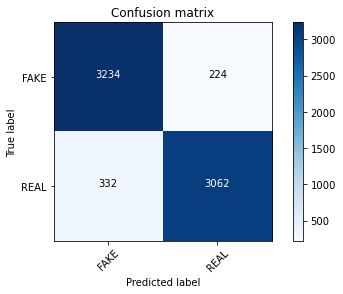

In [28]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Logistic Regression**

Accuracy score of the training data: 0.9673088149445418
Confusion matrix, without normalization


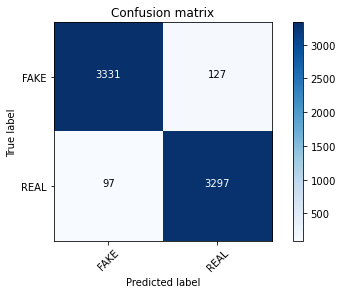

In [29]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(penalty = 'l2',solver='liblinear',C = 40, random_state=0)

model.fit(X_train,y_train)

X_train_prediction = model.predict(X_test)
training_data_accuracy = metrics.accuracy_score(X_train_prediction, y_test)
print('Accuracy score of the training data:',training_data_accuracy)
cm = metrics.confusion_matrix(y_test,X_train_prediction)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Accuracy score of the training data: 0.9014886164623468
Confusion matrix, without normalization


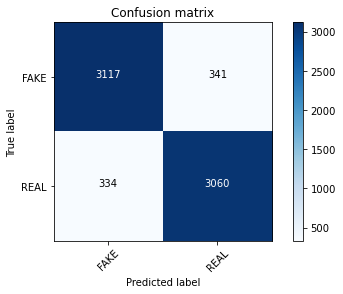

In [28]:
from sklearn.tree import DecisionTreeClassifier

DTree=DecisionTreeClassifier()

DTree.fit(X_train,y_train)

X_train_prediction = DTree.predict(X_test)
training_data_accuracy = metrics.accuracy_score(X_train_prediction, y_test)
print('Accuracy score of the training data:',training_data_accuracy)
cm = metrics.confusion_matrix(y_test,X_train_prediction)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Accuracy score of the training data: 0.9738762405137186
Confusion matrix, without normalization


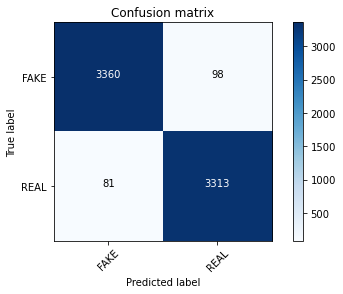

In [36]:
from sklearn.ensemble import  GradientBoostingClassifier

GBoost = GradientBoostingClassifier(n_estimators=3000,learning_rate=0.05,max_features='sqrt',min_samples_leaf=10, min_samples_split=5, random_state =0)

GBoost.fit(X_train,y_train)

X_train_prediction = GBoost.predict(X_test)
training_data_accuracy = metrics.accuracy_score(X_train_prediction, y_test)
print('Accuracy score of the training data:',training_data_accuracy)
cm = metrics.confusion_matrix(y_test,X_train_prediction)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [37]:
test=pd.read_csv('fake-news/test.csv')

In [38]:
test

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...
5198,25998,300 US Marines To Be Deployed To Russian Borde...,NaN,« Previous - Next » 300 US Marines To Be Deplo...


In [39]:
def test_preprocess(train_data,test_data,tfidf_v,maxnc,maxvc):
    test_data = test_data[test_data.text.notnull()]
    test_data['text'],test_data['Noun Count'],test_data['Verb Count'] = preprocess_corpus(test_data)
    tfidf_df_test = pd.DataFrame(tfidf_v.transform(test_data['text']).todense()) #to be concatenated
    tfidf_df_test.columns = sorted(tfidf_v.get_feature_names_out())
    idx = test_data['id']
    test_data.drop(labels = ['text','title','id'],axis = 1,inplace=True)
    test['author'] = test.author.apply(lambda x: str(x).replace(" ","")+"U" if isinstance(x, str) else " ")
    for a in list(train_data.columns[12002:]) : 
        test_data[a] = np.zeros(len(test_data),dtype=int)
        test_data[a][test_data.author == a] = 1 #in this col[a] put = 1 for indices where author == a
    test_data.drop(labels = ['author'],axis = 1,inplace=True)
    test_data.reset_index(drop=True,inplace = True)
    test_data["Noun Count"] = (test_data["Noun Count"])/maxnc
    test_data["Verb Count"] = (test_data["Verb Count"])/maxvc
    features = pd.concat([tfidf_df_test,test_data],axis = 1)
    return features,idx

In [40]:
test_feat,idx = test_preprocess(Features,test,tfidf_v,maxNumOfNouns,maxNumOfVerbs)
test_feat

,aaron,abandon,abc,abe,abedin,abil,abil to,abl,abl to,abort,...,BreitbartLondonU,BobPriceU,BenKewU,CharlieNashU,PakalertU,EddyLavineU,StarkmanU,AlexAnsaryU,GillianU,EditorU
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.07165,0.072031,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5188,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
5189,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.497746,...,0,0,0,0,0,0,0,0,0,0
5190,0.0,0.025883,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
5191,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [41]:
test_feat.columns[12002:]

Index(['PamKeyU', 'adminU', 'JeromeHudsonU', 'CharlieSpieringU',
       'JohnHaywardU', 'KatherineRodriguezU', 'WarnerToddHustonU',
       'IanHanchettU', 'BreitbartNewsU', 'DanielNussbaumU', 'JeffPoorU',
       'AWRHawkinsU', 'JoelB.PollakU', 'TrentBakerU', 'BreitbartLondonU',
       'BobPriceU', 'BenKewU', 'CharlieNashU', 'PakalertU', 'EddyLavineU',
       'StarkmanU', 'AlexAnsaryU', 'GillianU', 'EditorU'],
      dtype='object')

In [42]:
y_pred_test = GBoost.predict(test_feat.values)
y_pred_test

array([0, 1, 1, ..., 0, 1, 0])

In [43]:
submission=pd.DataFrame({'id':idx,'label':list(y_pred_test)})

In [44]:
submission.head(20)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
5,20805,1
6,20806,0
7,20807,1
8,20808,1
9,20809,1


In [45]:
submission.to_csv('Submission.csv', index=False)

In [46]:
out=pd.read_csv('Submission.csv')
out.head(20)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
5,20805,1
6,20806,0
7,20807,1
8,20808,1
9,20809,1
